In [1]:
import torch
import argparse
import numpy as np
import xarray as xr 
import yaml
from torch import optim
from numpy.lib.stride_tricks import sliding_window_view
import os
import sys
sys.path.append(r"C:\Users\Administrator\Desktop\code\LSTM\LSTM")
from utils.utils import Util
from model.LSTM import LSTMModel
from log.logging import setup_logger

def batch_predict(model, data, batch_size):
    model.eval()
    lat_block, lon_block, num_samples, time_step, channels = data.shape
    
    # 预先分配具有适当形状的 NumPy 数组（移除 time_step 和 channels 维度）
    predicted_samples = np.empty((lat_block, lon_block, num_samples))
    
    with torch.no_grad():
        for i in range(int(np.ceil(num_samples / batch_size))):
            batch_start = i * batch_size
            batch_end = min((i + 1) * batch_size, num_samples)
            for lat in range(lat_block):
                for lon in range(lon_block):
                    batch = data[lat, lon, batch_start:batch_end, :, :]
                    batch = torch.tensor(batch, dtype=torch.float32).to(device)
                    a = batch[1,:]
                    batch_predicted = model(batch).cpu().numpy()
                    if batch_predicted.shape != (batch_end - batch_start, 1):
                        batch_predicted = batch_predicted.reshape((batch_end - batch_start, 1))
                    predicted_samples[lat, lon, batch_start:batch_end] = batch_predicted[:, 0]
    
    return predicted_samples

def select_data(data_block, time_step):
    # (lat_block, lon_block, time, channels)
    lat_block, lon_block, time_len, channels = data_block.shape
    
    valid_time_indices = np.arange(time_step, time_len - 1)
    num_samples = len(valid_time_indices)
    idx = valid_time_indices.reshape(1, num_samples, 1) - np.arange(time_step).reshape(time_step, 1, 1)
    samples = data_block[:, :, idx, :]
    
    samples = np.squeeze(samples, axis=4)  # 移除维度是1的轴
    
    # (lat_block, lon_block, num_samples, time_step, channels)
    samples = np.transpose(samples, (0, 1, 3, 2, 4))
    samples = np.nan_to_num(samples)
    
    # 输出形状: (lat_block, lon_block, num_samples, time_step, channels)
    return samples

def reconstruct_data1(data, model, std, mean, time_step):
    # 数据形状
    time, lat, lon = data.time.shape[0], data.lat.shape[0], data.lon.shape[0]
    
    # 初始化重构数据的容器
    reconstructed_data = np.full((time, lat, lon), np.nan)
    lat_block_size = 10
    lon_block_size = 10
    
    # 循环遍历数据块
    for lat_start in range(0, lat, lat_block_size):
        for lon_start in range(0, lon, lon_block_size):
            # 计算块的结束索引
            lat_end = min(lat_start + lat_block_size, lat)
            lon_end = min(lon_start + lon_block_size, lon)
            
            # 提取当前块的数据
            data_block = data.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end)).to_array().compute().values  # [channels, time, lat_block, lon_block]at_block, lon_block]
            data_block = np.transpose(data_block, (2,3,1,0))  # 转换为 [lat_block, lon_block, time, channels]
            block_samples = select_data(data_block, time_step)
            predicted_samples = batch_predict(model, block_samples, 2000)
            predicted_samples = predicted_samples * std + mean
            predicted_samples = np.clip(predicted_samples, 0, 1)
            
            # 填充重构数据
            actual_lat_end = min(lat_start + lat_block_size, lat)
            actual_lon_end = min(lon_start + lon_block_size, lon)
            
            # 计算要填充的时间范围
            time_fill_start = time_step
        
            reconstructed_data[time_fill_start:-1, lat_start:actual_lat_end, lon_start:actual_lon_end] = predicted_samples[:, :, :].transpose(2, 0, 1)

            print(f"Processed block: lat {lat_start}-{actual_lat_end}, lon {lon_start}-{actual_lon_end}")

    return reconstructed_data

def reorder_variables(zarr_file_path, config_file_path):
    # 加载配置文件
    with open(config_file_path, 'r') as file:
        vars_config = yaml.safe_load(file)

    # 提取变量顺序
    vars_order = list(vars_config.keys())[1:]

    # 加载zarr文件
    data = xr.open_zarr(zarr_file_path,consolidated=True)

    # 确保所有配置文件中的变量都在zarr文件中
    missing_vars = [var for var in vars_order if var not in data.data_vars]
    if missing_vars:
        print(f"Warning: The following variables from the config are not present in the zarr file: {missing_vars}")
    
    # 按照配置文件中的顺序重新排列变量
    data_reordered = xr.Dataset({var: data[var] for var in vars_order if var in data.data_vars})

    print(f"Variables reordered according to the configuration.")
    return data_reordered

def main(args):
    model_argu = Util.load_config(args.model_config_path)
    path_argu = Util.load_config(args.path_config_path)
    missing_values = Util.load_config(args.vars_config_path)
    data_argu = Util.load_config(args.data_process_config_path)
    var_list = list(missing_values.keys())
    return model_argu, missing_values, var_list ,data_argu, path_argu

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_config_path', type=str, default='../config/model_config.yaml')
    parser.add_argument('--path_config_path', type=str, default='../config/path_config.yaml')
    parser.add_argument('--data_process_config_path', type=str, default='../config/data_process_config.yaml')
    parser.add_argument('--vars_config_path', type=str, default='../config/vars_config.yaml')

    args = parser.parse_known_args()[0]
    model_dict, missing_values, var_list ,data_argu, path_dict= main(args)

    logger = setup_logger(path_dict['log'])
    std = np.load(path_dict['std'])
    mean = np.load(path_dict['mean'])
    data = reorder_variables(path_dict['0.1_normal_Data'], r"C:\Users\Administrator\Desktop\code\ST-Conv\config\construct_Data\vars_config.yaml")

    #data = data.isel(time=slice(0, 100))
    
    model = LSTMModel(input_dim=model_dict['input_dim'], hidden_size=model_dict['hidden_size'],dropout_rate=model_dict['dropout_rate'])

    # 设定设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=model_dict['learning_rate'], weight_decay=model_dict['weight_decay'])  # 优化器

    # 加载模型
    Util.load_model_and_optimizer(model, optimizer, device, path_dict['LSTM_Best_Model'],logger=logger,model_index=-1)

    # 完整重建
    reconstructed_data = reconstruct_data1(data, model, std = std[0],mean = mean[0],time_step=56)
    file_path = file_path = os.path.join(path_dict['LSTM_Reconstruction'], '/LSTM' + '.npy')
    np.save(file_path,reconstructed_data)

Variables reordered according to the configuration.


INFO: Model loaded from D:\Data_Store\Model\LSTM\Check_point\best_epoch36_20240125150201.pth


Processed block: lat 0-10, lon 0-10
Processed block: lat 0-10, lon 10-20


In [2]:
import torch
import time
import argparse
import numpy as np
import xarray as xr 
from torch import optim
import dask
import os
import yaml
from dask.distributed import Client

import sys
sys.path.append(r"C:\Users\Administrator\Desktop\code\LSTM\LSTM")
from utils.utils import Util
from model.LSTM import LSTMModel
from log.logging import setup_logger
import torch.nn as nn

def batch_predict(model, data, batch_size):
    model.eval()
    lat_block, lon_block, num_samples, time_step, channels = data.shape
    
    # 预先分配具有适当形状的 NumPy 数组（移除 time_step 和 channels 维度）
    predicted_samples = np.empty((lat_block, lon_block, num_samples))
    
    with torch.no_grad():
        for i in range(int(np.ceil(num_samples / batch_size))):
            batch_start = i * batch_size
            batch_end = min((i + 1) * batch_size, num_samples)
            for lat in range(lat_block):
                for lon in range(lon_block):
                    batch = data[lat, lon, batch_start:batch_end, :, :]
                    batch = torch.tensor(batch, dtype=torch.float32).to(device)
                    a = batch[1,:]
                    batch_predicted = model(batch).cpu().numpy()
                    if batch_predicted.shape != (batch_end - batch_start, 1):
                        batch_predicted = batch_predicted.reshape((batch_end - batch_start, 1))
                    predicted_samples[lat, lon, batch_start:batch_end] = batch_predicted[:, 0]
    
    return predicted_samples

def select_data(data_block, time_step):
    # (lat_block, lon_block, time, channels)
    lat_block, lon_block, time_len, channels = data_block.shape
    
    valid_time_indices = np.arange(time_step, time_len - 1)
    num_samples = len(valid_time_indices)
    idx = valid_time_indices.reshape(1, num_samples, 1) - np.arange(time_step).reshape(time_step, 1, 1)
    samples = data_block[:, :, idx, :]
    
    samples = np.squeeze(samples, axis=4)  # 移除维度是1的轴
    
    # (lat_block, lon_block, num_samples, time_step, channels)
    samples = np.transpose(samples, (0, 1, 3, 2, 4))
    samples = np.nan_to_num(samples)
    
    # 输出形状: (lat_block, lon_block, num_samples, time_step, channels)
    return samples

def reconstruct_data1(data, model, std, mean, time_step):
    # 数据形状
    time, lat, lon = data.time.shape[0], data.lat.shape[0], data.lon.shape[0]
    
    # 初始化重构数据的容器
    reconstructed_data = np.full((time, lat, lon), np.nan)
    lat_block_size = 10
    lon_block_size = lon
    
    # 循环遍历数据块
    for lat_start in range(0, lat, lat_block_size):
        for lon_start in range(0, lon, lon_block_size):
            # 计算块的结束索引
            lat_end = min(lat_start + lat_block_size, lat)
            lon_end = min(lon_start + lon_block_size, lon)
            
            # 提取当前块的数据
            data_block = data.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end)).to_array().compute().values  # [channels, time, lat_block, lon_block]at_block, lon_block]
            data_block = np.transpose(data_block, (2,3,1,0))  # 转换为 [lat_block, lon_block, time, channels]
            block_samples = select_data(data_block, time_step)
            predicted_samples = batch_predict(model, block_samples, 20000)
            predicted_samples = predicted_samples * std + mean
            predicted_samples = np.clip(predicted_samples, 0, 1)
            
            # 填充重构数据
            actual_lat_end = min(lat_start + lat_block_size, lat)
            actual_lon_end = min(lon_start + lon_block_size, lon)
            
            # 计算要填充的时间范围
            time_fill_start = time_step
        
            reconstructed_data[time_fill_start:-1, lat_start:actual_lat_end, lon_start:actual_lon_end] = predicted_samples[:, :, :].transpose(2, 0, 1)

            print(f"Processed block: lat {lat_start}-{actual_lat_end}, lon {lon_start}-{actual_lon_end}")
            np.save('/root/LSTM/reconstruction/LSTM_0.37.npy',reconstructed_data)
    return reconstructed_data

def reorder_variables(zarr_file_path, config_file_path):
    # 加载配置文件
    with open(config_file_path, 'r') as file:
        vars_config = yaml.safe_load(file)

    # 提取变量顺序
    vars_order = list(vars_config.keys())

    # 加载zarr文件
    data = xr.open_zarr(zarr_file_path,consolidated=True)

    # 确保所有配置文件中的变量都在zarr文件中
    missing_vars = [var for var in vars_order if var not in data.data_vars]
    if missing_vars:
        print(f"Warning: The following variables from the config are not present in the zarr file: {missing_vars}")
    
    # 按照配置文件中的顺序重新排列变量
    data_reordered = xr.Dataset({var: data[var] for var in vars_order if var in data.data_vars})

    print(f"Variables reordered according to the configuration.")
    return data_reordered

def main(args):
    model_argu = Util.load_config(args.model_config_path)
    path_argu = Util.load_config(args.path_config_path)
    missing_values = Util.load_config(args.vars_config_path)
    data_argu = Util.load_config(args.data_process_config_path)
    var_list = list(missing_values.keys())
    return model_argu, missing_values, var_list ,data_argu, path_argu

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_config_path', type=str, default='../config/model_config.yaml')
    parser.add_argument('--path_config_path', type=str, default='../config/path_config.yaml')
    parser.add_argument('--data_process_config_path', type=str, default='../config/data_process_config.yaml')
    parser.add_argument('--vars_config_path', type=str, default='../config/vars_config.yaml')

    args = parser.parse_known_args()[0]
    model_dict, missing_values, var_list ,data_argu, path_dict= main(args)

    logger = setup_logger(path_dict['log'])
    std = np.load(path_dict['std'])
    mean = np.load(path_dict['mean'])
    #data = reorder_variables(path_dict['0.1_normal_Data'], r"/root/LSTM/config/vars_config.yaml")
    data = reorder_variables(r"D:\Data_Store\Dataset\Original_Data\0.37_normal_Data.zarr", r"C:\Users\Administrator\Desktop\code\ST-Conv\config\construct_Data\vars_config.yaml")
    #data = data.isel(time=slice(0, 100))
    
    model = LSTMModel(input_dim=model_dict['input_dim'], hidden_size=model_dict['hidden_size'],dropout_rate=model_dict['dropout_rate'])

    # 设定设备
    if torch.cuda.device_count() > 1:
        print(f"Let's use {torch.cuda.device_count()} GPUs!")
    # 封装模型以在多GPU上运行
    
    model = nn.DataParallel(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=model_dict['learning_rate'], weight_decay=model_dict['weight_decay'])  # 优化器

    # 加载模型
    Util.load_model_and_optimizer1(model, optimizer, device, path_dict['LSTM_Best_Model'],logger=logger,model_index=-1)

    # 完整重建
    reconstructed_data = reconstruct_data1(data, model, std = std[0],mean = mean[0],time_step=56)


INFO: Model loaded from D:\Data_Store\Model\LSTM\Check_point\best_epoch36_20240125150201.pth


Variables reordered according to the configuration.


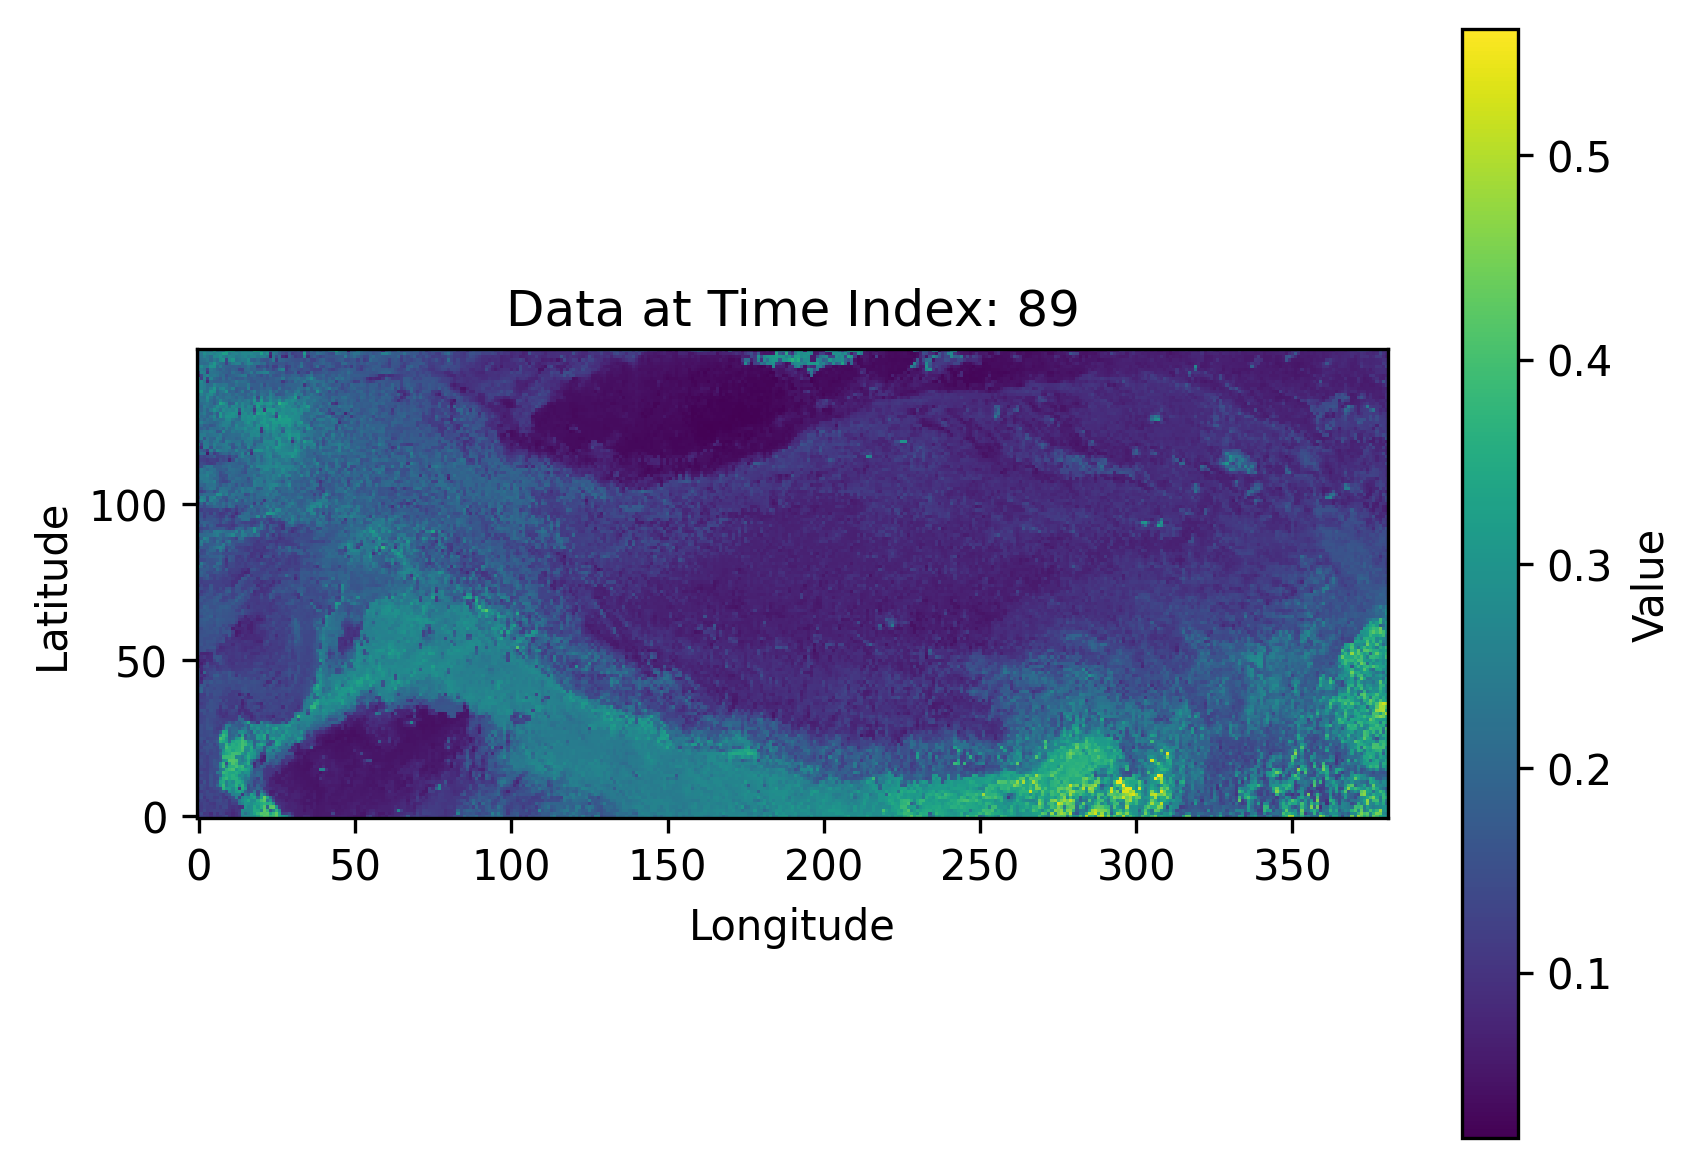

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
#"D:\\Data_Store\\Dataset\\Reconstruction\\ST\\RES\\0.1reconstruct_point.npy"
#file_path = "D:\\Data_Store\\Dataset\\Reconstruction\\ST\\RES\\0.1reconstruct.npy"
#data = np.load(file_path)
#reconstructed_data[reconstructed_data > 1] = 1
#reconstructed_data[reconstructed_data < 0] = 0
# 随机选择一个时间点绘制图像
# 假设时间是数据的第一个维度
time_index = 89
data = reconstructed_data
selected_time_data = data[time_index]
# 绘制图像DPI=300
plt.figure(dpi=300)
plt.imshow(selected_time_data, cmap='viridis', origin='lower')
plt.colorbar(label='Value')
plt.title(f"Data at Time Index: {time_index}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


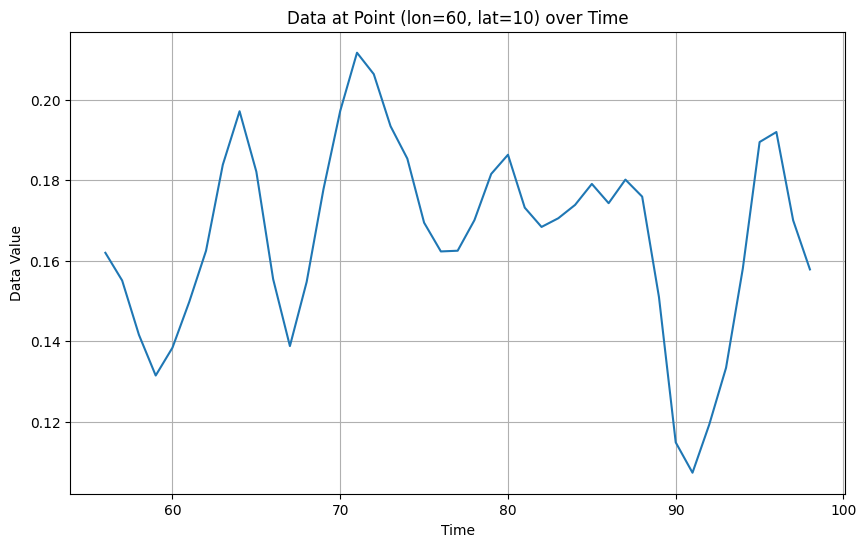

In [6]:
import matplotlib.pyplot as plt

# 确保你已经有了 reconstructed_data，它的形状是 (time, lon, lat)
# ...

# 选择一个点 (lon_idx, lat_idx)
lon_idx = 60  # 例如选择经度索引为 0 的位置
lat_idx = 10  # 例如选择纬度索引为 0 的位置

# 提取该点在所有时间点上的数据
point_data = reconstructed_data[:, lon_idx, lat_idx]

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(point_data)
plt.title(f'Data at Point (lon={lon_idx}, lat={lat_idx}) over Time')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.grid(True)
plt.show()


In [8]:
import torch
import time
import argparse
import numpy as np
import xarray as xr 
from torch import optim
import dask
from dask.distributed import Client
import os
import sys
sys.path.append(r"C:\Users\Administrator\Desktop\code\LSTM\LSTM")
from utils.utils import Util
from model.LSTM import LSTMModel
from log.logging import setup_logger


def main(args):
    model_argu = Util.load_config(args.model_config_path)
    path_argu = Util.load_config(args.path_config_path)
    missing_values = Util.load_config(args.vars_config_path)
    data_argu = Util.load_config(args.data_process_config_path)
    var_list = list(missing_values.keys())
    return model_argu, missing_values, var_list ,data_argu, path_argu

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_config_path', type=str, default='../config/model_config.yaml')
    parser.add_argument('--path_config_path', type=str, default='../config/path_config.yaml')
    parser.add_argument('--data_process_config_path', type=str, default='../config/data_process_config.yaml')
    parser.add_argument('--vars_config_path', type=str, default='../config/vars_config.yaml')

    args = parser.parse_known_args()[0]
    model_dict, missing_values, var_list ,data_argu, path_dict= main(args)

    logger = setup_logger(path_dict['log'])
    std = np.load(path_dict['mean'])
    mean = np.load(path_dict['std'])
    data = xr.open_zarr(path_dict['0.1_normal_Data'])
    data = data.isel(time=slice(0, 60))
    

In [1]:
import xarray as xr
import numpy as np

# 加载数据
original_data = xr.open_dataset(r"D:\Data_Store\Dataset\Original_Data\0.1_Data.nc")
training_data = xr.open_dataset(r"D:\Data_Store\Dataset\Original_Data\0.37_Data.nc")
reconstructed_data = xr.open_zarr(r"D:\Data_Store\Dataset\Original_Data\0.1_normal_Data.zarr")
reconstructed2_data = xr.open_zarr(r"D:\Data_Store\Dataset\Original_Data\0.37_normal_Data.zarr")
# 设置 lon 和 lat 的值
lon_value = 0  # 示例 lon 值
lat_value = 0  # 示例 lat 值

# 获取所有数据集中共有的变量名列表
common_variables = set(original_data.data_vars.keys()) & set(reconstructed_data.data_vars.keys()) & set(training_data.data_vars.keys())& set(reconstructed2_data.data_vars.keys())

# 循环输出每个变量的标准差和均值
for var_name in common_variables:
    print(f"Variable: {var_name}")

    # 处理原始数据
    original_var = original_data[var_name].isel(lon=lon_value, lat=lat_value)
    # 替换极端值
    original_var = xr.where((original_var < 1e6) & (original_var > -1e6), original_var, np.nan)
    # 计算标准差和均值
    print(f"Original Data STD: {original_var.std(dim='time', skipna=True).values}")
    original_var = original_var.fillna(0)  # 将 NaN 值转换为 0
    print(f"Original Data Mean: {original_var.mean(dim='time').values}")

    # 处理训练数据
    training_var = training_data[var_name].isel(lon=lon_value, lat=lat_value)
    # 替换极端值
    training_var = xr.where((training_var < 1e6) & (training_var > -1e6), training_var, np.nan)
    # 计算标准差和均值
    print(f"Training Data STD: {training_var.std(dim='time', skipna=True).values}")
    training_var = training_var.fillna(0)  # 将 NaN 值转换为 0
    print(f"Training Data Mean: {training_var.mean(dim='time').values}")

    # 处理重建数据
    reconstructed_var = reconstructed_data[var_name].isel(lon=lon_value, lat=lat_value)
    # 替换极端值
    reconstructed_var = xr.where((reconstructed_var < 1e6) & (reconstructed_var > -1e6), reconstructed_var, np.nan)
    # 计算标准差和均值
    print(f"Reconstructed Data STD: {reconstructed_var.std(dim='time', skipna=True).values}")
    reconstructed_var = reconstructed_var.fillna(0)  # 将 NaN 值转换为 0
    print(f"Reconstructed Data Mean: {reconstructed_var.mean(dim='time').values}")
    
    # 处理新增的重建数据2
    reconstructed2_var = reconstructed2_data[var_name].isel(lon=lon_value, lat=lat_value)
    # 替换极端值
    reconstructed2_var = xr.where((reconstructed2_var < 1e6) & (reconstructed2_var > -1e6), reconstructed2_var, np.nan)
    print(f"Reconstructed2 Data STD: {reconstructed2_var.std(dim='time', skipna=True).values}")
    reconstructed2_var = reconstructed2_var.fillna(0)
    print(f"Reconstructed2 Data Mean: {reconstructed2_var.mean(dim='time').values}")

    print("-" * 40)  # 分隔线

Variable: Slope
Original Data STD: 0.0028076171875
Original Data Mean: 89.98660278320312
Training Data STD: 0.0049360329285264015
Training Data Mean: 88.51469421386719
Reconstructed Data STD: 3.3788523090549916e-09
Reconstructed Data Mean: 0.3798280656337738
Reconstructed2 Data STD: 4.234064654440317e-09
Reconstructed2 Data Mean: 0.2171107828617096
----------------------------------------
Variable: Albedo_WSA_Band4
Original Data STD: 0.0
Original Data Mean: 0.02891804277896881
Training Data STD: 797.9688110351562
Training Data Mean: 245.74960327148438
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -2.136453076673206e-05
Reconstructed2 Data STD: 0.37079259753227234
Reconstructed2 Data Mean: -0.04460962489247322
----------------------------------------
Variable: as_dem_3s
Original Data STD: 0.04772934690117836
Original Data Mean: 1185.609619140625
Training Data STD: 0.041076067835092545
Training Data Mean: 685.847412109375
Reconstructed Data STD: 3.729336839342068e-08
Reconstructed

c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: Albedo_BSA_Band7
Original Data STD: 0.0
Original Data Mean: 0.014745743945240974
Training Data STD: 782.3140869140625
Training Data Mean: 289.4327392578125
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -1.6098843843792565e-05
Reconstructed2 Data STD: 0.36843422055244446
Reconstructed2 Data Mean: -0.009680184535682201
----------------------------------------
Variable: Albedo_WSA_Band7
Original Data STD: 0.0
Original Data Mean: 0.014158520847558975
Training Data STD: 781.0960693359375
Training Data Mean: 296.0583801269531
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -1.6233456335612573e-05
Reconstructed2 Data STD: 0.36914825439453125
Reconstructed2 Data Mean: -0.0099143385887146
----------------------------------------
Variable: soil_temperature_level_1
Original Data STD: 11.216500282287598
Original Data Mean: 287.7518615722656
Training Data STD: 11.348601341247559

c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: surface_sensible_heat_flux_hourly
Original Data STD: 232257.28125
Original Data Mean: -96894.5703125
Training Data STD: 251802.140625
Training Data Mean: -120056.2734375
Reconstructed Data STD: 1.5863510370254517
Reconstructed Data Mean: -0.6224066615104675


c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: Albedo_WSA_Band2
Original Data STD: 0.0
Original Data Mean: 0.035540711134672165
Training Data STD: 790.4017944335938
Training Data Mean: 347.85760498046875
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -2.2948272089706734e-05
Reconstructed2 Data STD: 0.37247416377067566
Reconstructed2 Data Mean: -0.049335651099681854
----------------------------------------
Variable: EVI
Original Data STD: 558.9052124023438
Original Data Mean: 1607.39111328125
Training Data STD: 439.2552185058594
Training Data Mean: 1344.972412109375
Reconstructed Data STD: 0.17552199959754944
Reconstructed Data Mean: -0.5318849682807922
Reconstructed2 Data STD: 0.14698609709739685
Reconstructed2 Data Mean: -0.5426302552223206
----------------------------------------
Variable: clay_0-5cm_mean
Original Data STD: 0.008087385445833206
Original Data Mean: 299.5328674316406
Training Data STD: 0.0243845134973

c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: Albedo_BSA_shortwave
Original Data STD: 0.0
Original Data Mean: 0.028588009998202324
Training Data STD: 801.655029296875
Training Data Mean: 285.4666442871094
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -2.1344438209780492e-05
Reconstructed2 Data STD: 0.3688119053840637
Reconstructed2 Data Mean: -0.03495969623327255
----------------------------------------
Variable: Albedo_WSA_shortwave
Original Data STD: 0.0
Original Data Mean: 0.027640707790851593
Training Data STD: 799.9029541015625
Training Data Mean: 292.3215026855469
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -2.1647874746122397e-05
Reconstructed2 Data STD: 0.36956414580345154
Reconstructed2 Data Mean: -0.035206280648708344
----------------------------------------
Variable: Albedo_BSA_Band4
Original Data STD: 0.0
Original Data Mean: 0.029928455129265785
Training Data STD: 799.4525756835938
Training Data

c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: LST_Day_1km
Original Data STD: 342.9049987792969
Original Data Mean: 4749.88134765625
Training Data STD: 314.5008239746094
Training Data Mean: 201.69927978515625
Reconstructed Data STD: 0.507489025592804
Reconstructed Data Mean: 0.23828378319740295


c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: total_evaporation_hourly
Original Data STD: 8.06503594503738e-05
Original Data Mean: -4.404885839903727e-05
Training Data STD: 6.663046224275604e-05
Training Data Mean: -5.7890683820005506e-05
Reconstructed Data STD: 0.46014636754989624
Reconstructed Data Mean: 0.37098371982574463


c:\Anaconda\envs\MLL\lib\site-packages\dask\array\numpy_compat.py:51: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reconstructed2 Data STD: nan
Reconstructed2 Data Mean: 0.0
----------------------------------------
Variable: Albedo_BSA_Band5
Original Data STD: 0.0
Original Data Mean: 0.026896201074123383
Training Data STD: 785.3642578125
Training Data Mean: 352.6239929199219
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -2.0894938643323258e-05
Reconstructed2 Data STD: 0.3710637092590332
Reconstructed2 Data Mean: -0.03680089861154556
----------------------------------------
Variable: Albedo_BSA_Band1
Original Data STD: 0.0
Original Data Mean: 0.031107261776924133
Training Data STD: 800.34912109375
Training Data Mean: 270.7033996582031
Reconstructed Data STD: 0.0
Reconstructed Data Mean: -2.069762922474183e-05
Reconstructed2 Data STD: 0.37169012427330017
Reconstructed2 Data Mean: -0.037909429520368576
----------------------------------------
Variable: sand_0-5cm_mean
Original Data STD: 0.004974595736712217
Original Data Mean: 281.07415771484375
Training Data STD: 0.01190196629613638
Training D

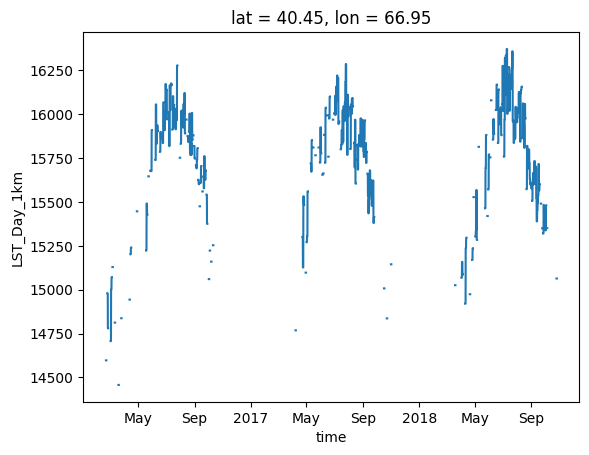

In [1]:
import xarray as xr
original_data = xr.open_dataset(r"D:\Data_Store\Dataset\Original_Data\0.1_Data.nc")
original_data = original_data.isel(lon=0,lat=0)
#original_data.Albedo_BSA_Band1.plot()
# 将大于20000的设置为nan
#original_data = original_data.where(original_data.Albedo_BSA_Band1 < 2000)
original_data.LST_Day_1km.plot()
# 沿着lon和lat计算均值
#original_data.Albedo_BSA_Band1.mean(dim=['lon', 'lat'])


Training Data STD: 1799.4881591796875
Training Data Mean: 671.8843994140625


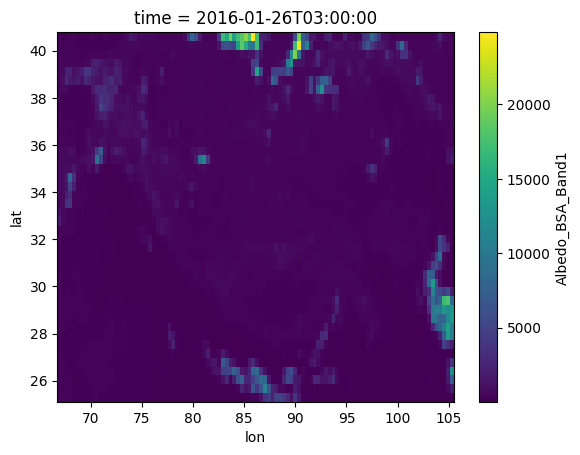

In [36]:
import numpy as np 
import xarray as xr

var_name = 'Albedo_BSA_Band1'
training_data = xr.open_dataset(r"D:\Data_Store\Dataset\Original_Data\0.37_Data.nc")
training_var = training_data.Albedo_BSA_Band1.isel(time=200)
# 替换极端值
training_var = xr.where((training_var < 1e9) & (training_var > -1e9), training_var, np.nan)
# 计算标准差和均值
print(f"Training Data STD: {training_var.std(dim=['lon', 'lat'], skipna=True).values}")
training_var = training_var.fillna(0)  # 将 NaN 值转换为 0
print(f"Training Data Mean: {training_var.mean(dim=['lon', 'lat']).values}")

training_var.plot()

In [ ]:
import numpy as np 
import xarray as xr

var_name = 'Albedo_BSA_Band1'
training_data = xr.open_zarr(r"D:\Data_Store\Dataset\Original_Data\0.1_normal_Data.zarr")
training_var = training_data.Albedo_BSA_Band1.isel(time=200)
# 替换极端值
training_var = xr.where((training_var < 1e9) & (training_var > -1e9), training_var, np.nan)
# 计算标准差和均值
print(f"Training Data STD: {training_var.std(dim=['lon', 'lat'], skipna=True).values}")
training_var = training_var.fillna(0)  # 将 NaN 值转换为 0
print(f"Training Data Mean: {training_var.mean(dim=['lon', 'lat']).values}")

training_var.plot()

In [3]:
training_data = xr.open_zarr(r"D:\Data_Store\Dataset\Original_Data\0.1_normal_Data.zarr")
training_data.total_evaporation_hourly.isel(time=0).plot()

<xarray.Dataset>
Dimensions:                               (time: 8768, lat: 150, lon: 381)
Coordinates:
  * lat                                   (lat) float32 25.55 25.65 ... 40.45
  * lon                                   (lon) float32 66.95 67.05 ... 105.0
  * time                                  (time) datetime64[ns] 2016-01-01T03...
Data variables: (12/41)
    Albedo_BSA_Band1                      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    Albedo_BSA_Band2                      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    Albedo_BSA_Band3                      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    Albedo_BSA_Band4                      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    Albedo_BSA_Band5                      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    Albedo_BSA_Band6                      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    ...                                    ...
    soil_temperature_level_1              (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    surface_latent_heat_flux_hourly       (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    surface_net_solar_radiation_hourly    (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    surface_net_thermal_radiation_hourly  (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    surface_sensible_heat_flux_hourly     (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>
    total_evaporation_hourly              (time, lat, lon) float32 dask.array<chunksize=(1, 150, 381), meta=np.ndarray>

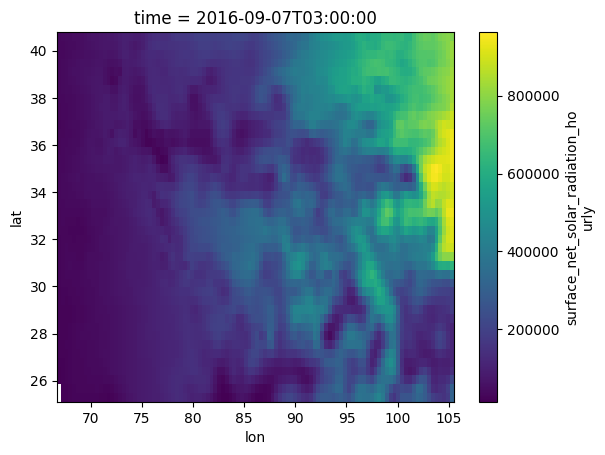

In [17]:
training_data.surface_net_solar_radiation_hourly.isel(time=2000).plot()

In [6]:

reconstructed2_data = xr.open_zarr(r"D:\Data_Store\Dataset\Original_Data\0.37_normal_Data.zarr")
reconstructed2_data


<xarray.Dataset>
Dimensions:                               (time: 8768, lat: 42, lon: 104)
Coordinates:
  * lat                                   (lat) float32 25.29 25.67 ... 40.6
  * lon                                   (lon) float32 66.85 67.22 ... 105.3
  * time                                  (time) datetime64[ns] 2016-01-01T03...
Data variables: (12/41)
    Albedo_BSA_Band1                      (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    Albedo_BSA_Band2                      (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    Albedo_BSA_Band3                      (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    Albedo_BSA_Band4                      (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    Albedo_BSA_Band5                      (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    Albedo_BSA_Band6                      (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    ...                                    ...
    soil_temperature_level_1              (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    surface_latent_heat_flux_hourly       (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    surface_net_solar_radiation_hourly    (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    surface_net_thermal_radiation_hourly  (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    surface_sensible_heat_flux_hourly     (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>
    total_evaporation_hourly              (time, lat, lon) float32 dask.array<chunksize=(1, 42, 104), meta=np.ndarray>

In [1]:
import numpy as np
file_path = "D:\Data_Store\Dataset\LSTM\data_batch_5.npy"
data = np.load(file_path)
data = data[0,:]

In [2]:
data

array([[        nan, -0.2380913 ,  1.37329566, ...,  0.24982672,
         0.12375333, -0.97526436],
       [        nan, -0.2380913 ,  1.37329566, ...,  0.24982672,
         0.12375333, -0.97407911],
       [        nan, -0.2380913 ,  1.37329566, ...,  0.24982672,
         0.12375333, -0.97289386],
       ...,
       [        nan, -0.2380913 ,  1.37329566, ...,  0.24982672,
         0.12375333, -0.91126097],
       [        nan, -0.2380913 ,  1.37329566, ...,  0.24982672,
         0.12375333, -0.91007572],
       [-0.88933289, -0.2380913 ,  1.37329566, ...,  0.24982672,
         0.12375333, -0.90889048]])